# CNET 5442 — Sports Analytics Through Data and Networks (Spring 2026)  
## Class 04 — Distributions, Odds, and Surprises


This notebook is the **in-class companion** to the Class 04 slides.

We’ll do two things in parallel:

1. Build intuition with **toy simulations** (so everything runs even without soccer data).
2. Apply the ideas to a real dataset: **EPL 2024 shots**.

> Big idea: a probability model is a *recipe for generating data*.  
> A distribution is the "fingerprint" that recipe leaves behind.

This notebook is from https://github.com/jkbren/cnet5442_sp26

## What you should be able to do after today

- Define **random variables**, **PMF/PDF/CDF**, **expectation**, and **variance**
- Explain why repeated sampling produces a **stable empirical distribution**
- Simulate and interpret core distributions that show up in sports:
  - Bernoulli / Binomial (success counts)
  - Poisson (event counts per interval)
  - Geometric / Exponential (waiting times)
- Connect **odds ↔ implied probabilities**, and compute a bookmaker **margin (overround)**
- Quantify "how unlikely" with **surprisal**: $ -\log_2(p) $
- Use soccer shot/goal data to test a simple model:
  - "goals occur with constant probability per minute"
- Preview next class: how these ideas become **regression**


---

## Data used in the second half

This notebook expects a file at:

- `data/EPL_2024_shots.csv`

If you don’t have the file, everything through the "toy simulation" sections still works.


## Common packages and setup that we (I) often use

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', axisbelow=True)
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

In [2]:
# Reproducibility for random demos
rng = np.random.default_rng(5)

In [3]:
# Arrays and vectorized operations
x = np.array([1, 2, 3, 4, 5])
x, x.mean(), x.std()

(array([1, 2, 3, 4, 5]), 3.0, 1.4142135623730951)

In [4]:
# Random numbers (Uniform[0,1])
u = rng.random(5)
u


array([0.80500292, 0.80794079, 0.51532556, 0.28580138, 0.0539307 ])

In [5]:
# Bernoulli trials (1 with prob p, else 0) using Binomial(n=1, p)
p = 0.7
trials = rng.binomial(n=1, p=p, size=20)
trials, trials.mean()


(array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]), 0.75)

In [6]:
# Boolean masking: keep only the successes
trials[trials == 1]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Probability basics (minimal but useful)

### Events and probabilities
- A **sample space** $\Omega$ contains all possible outcomes.
- An **event** $A \subseteq \Omega$ is a set of outcomes.
- A **probability** assigns numbers $P(A) \in [0,1]$.

### Random variables
A **random variable** $X$ maps outcomes to numbers (e.g., goals scored, time until next goal).

### Distributions
- **PMF** (discrete): $P(X=x)$
- **CDF**: $F(x)=P(X \le x)$

### Expectation and variance
- $E[X]$ is the long-run average of $X$ (if we could repeat the world).
- $\mathrm{Var}(X)$ measures spread around $E[X]$.

A useful identity: $ \mathrm{Var}(X)=E[(X-E[X])^2] $


________
## From repeated samples to a distribution

Let’s build the simplest example:

- One coin flip is a Bernoulli random variable.
- The number of heads in $n$ flips is Binomial.
- If we repeat "$n$ flips" many times, the histogram stabilizes.

This is the practical meaning of *"a distribution."*


In [7]:
# Repeated sampling: number of heads in n flips
n = 10
p = 0.5
N = 10_000  # number of repeated experiments

In [8]:
# Each experiment = n flips; count heads
heads = rng.binomial(n=n, p=p, size=N)

In [10]:
from pathlib import Path
from typing import Optional
import math
from math import comb

def binom_pmf(k: np.ndarray, n: int, p: float) -> np.ndarray:
    """Binomial PMF evaluated at integer k values."""
    return np.array([comb(n, int(ki)) * (p**int(ki)) * ((1-p)**(n-int(ki))) for ki in k], dtype=float)

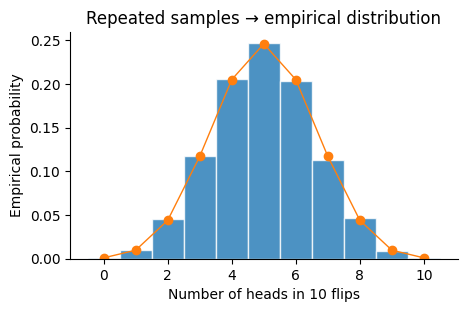

In [11]:
# Empirical distribution (histogram)
fig, ax = plt.subplots(figsize=(5,3), dpi=100)
ax.hist(heads, bins=np.arange(-0.5, n+1.5, 1), density=True, alpha=0.8, edgecolor='white')
ax.set_xlabel(f'Number of heads in {n} flips')
ax.set_ylabel('Empirical probability')
ax.set_title('Repeated samples → empirical distribution')

# Theoretical Binomial PMF
k = np.arange(0, n+1)
pmf = binom_pmf(k, n=n, p=p)
ax.plot(k, pmf, marker='o', linewidth=1)

ax.spines[['right','top']].set_visible(False)
plt.show()


### Try it

- Change `p` to 0.6 or 0.8. What happens to the center and the spread?
- Change `n` to 20. Does the distribution look “more normal”?


## Law of Large Numbers (LLN): what you see in practice

If $X_1, X_2, \dots$ are i.i.d. with mean $\mu$, the sample mean

$$
\bar X_n = \frac{1}{n}\sum_{i=1}^n X_i
$$

gets closer to $\mu$ as $n$ grows.

**Translation:** averages become stable, even when individual outcomes stay random.


In [12]:
# LLN in one picture: running average of Bernoulli trials
p_true = 0.3
N = 5_000

x = rng.binomial(n=1, p=p_true, size=N)
running_mean = np.cumsum(x) / np.arange(1, N+1)

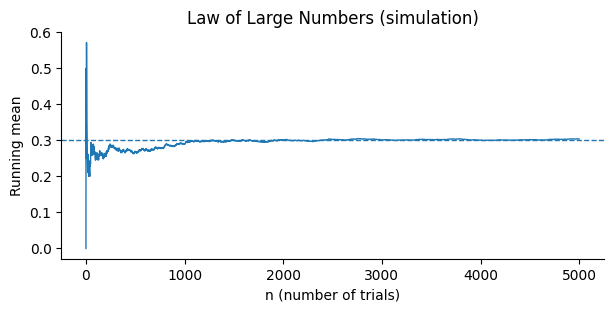

In [13]:
fig, ax = plt.subplots(figsize=(7,3), dpi=100)

ax.plot(running_mean, linewidth=1)
ax.axhline(p_true, linestyle='--', linewidth=1)
ax.set_xlabel('n (number of trials)')
ax.set_ylabel('Running mean')
ax.set_title('Law of Large Numbers (simulation)')
ax.spines[['right','top']].set_visible(False)

plt.show()

In [14]:
# Distribution of sample means shrinks as n grows
p_true = 0.3
M = 8_000  # number of repeated experiments
ns = [10, 50, 200, 1000]

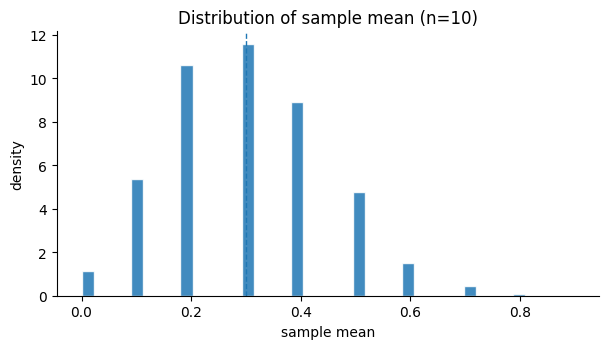

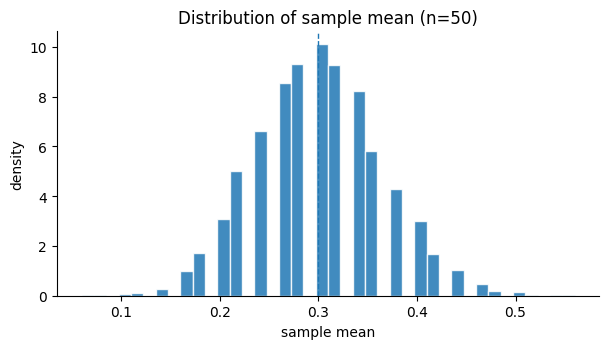

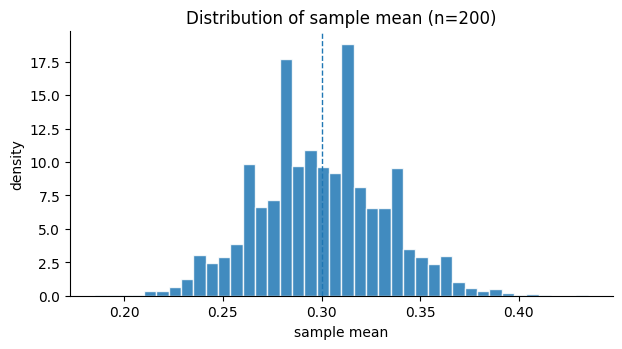

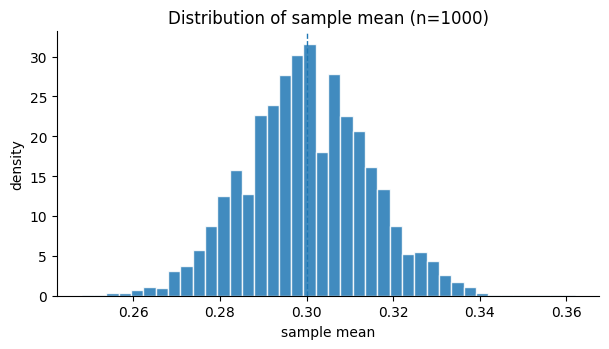

In [15]:
for n in ns:
    means = rng.binomial(n=1, p=p_true, size=(M, n)).mean(axis=1)
    fig, ax = plt.subplots(figsize=(7,3.5), dpi=100)
    ax.hist(means, bins=40, density=True, alpha=0.85, edgecolor='white')
    ax.axvline(p_true, linestyle='--', linewidth=1)
    ax.set_title(f'Distribution of sample mean (n={n})')
    ax.set_xlabel('sample mean')
    ax.set_ylabel('density')
    ax.spines[['right','top']].set_visible(False)
    plt.show()


In [16]:
def poisson_pmf(k: np.ndarray, lam: float) -> np.ndarray:
    """Poisson PMF evaluated at integer k values."""
    k = np.asarray(k, dtype=int)
    return np.array([(lam**ki) * np.exp(-lam) / math.factorial(ki) for ki in k], dtype=float)

def geometric_pmf(k: np.ndarray, p: float) -> np.ndarray:
    """Geometric PMF for waiting time k=1,2,... (trials until first success)."""
    k = np.asarray(k, dtype=int)
    return ((1-p)**(k-1)) * p

## Core distributions that show up in sports

### Bernoulli (one attempt)
- Outcome $\in\{0,1\}$, success with probability $p$
- Examples: free throw, penalty kick, does this shot score?

### Binomial (how many successes in $n$ attempts?)

$$
S_n \sim \mathrm{Binomial}(n,p),\qquad E[S_n]=np,\quad \mathrm{Var}(S_n)=np(1-p)
$$

### Poisson (how many events in a time window?)

$$
N(T)\sim \mathrm{Poisson}(\lambda T),\qquad E[N(T)] = \lambda T
$$

Examples: goals in a match (as a baseline), fouls per game, injuries per season (sometimes).

### Geometric (waiting time in discrete time)
If each minute is a “trial” with goal-probability $p$, the waiting time (in minutes) until the next goal is:

$$
P(\Delta = k) = (1-p)^{k-1}p
$$

**Key property:** memoryless.

### Exponential (waiting time in continuous time)
Continuous-time analog of geometric:

$$
P(\Delta > t) = e^{-\lambda t}
$$


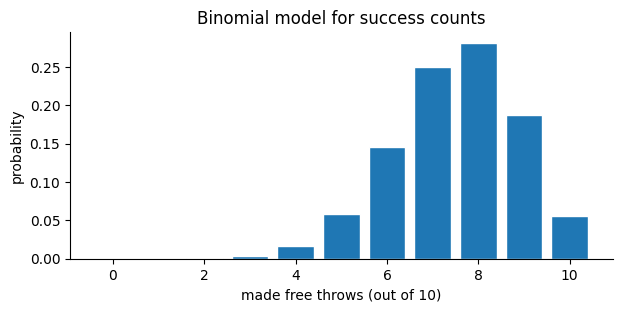

P(miss all 10) = 9.5367431640625e-07
P(make at least 8) = 0.5255928039550781


In [17]:
# Binomial example: free throws
p = 0.75   # free throw % (toy)
n = 10     # attempts

k = np.arange(0, n+1)
pmf = binom_pmf(k, n=n, p=p)

fig, ax = plt.subplots(figsize=(7,3), dpi=100)
ax.bar(k, pmf, edgecolor='white')
ax.set_xlabel('made free throws (out of 10)')
ax.set_ylabel('probability')
ax.set_title('Binomial model for success counts')
ax.spines[['right','top']].set_visible(False)
plt.show()

print("P(miss all 10) =", (1-p)**n)
print("P(make at least 8) =", pmf[k>=8].sum())


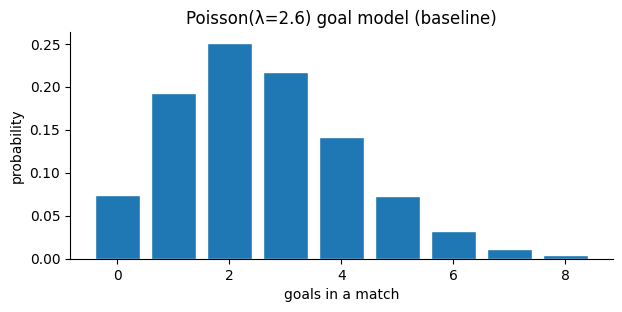

P(0-0) under Poisson = 0.07427357821433388


In [18]:
# Poisson example (toy): goals per match baseline
lam = 2.6  # average goals per match (toy)
k = np.arange(0, 9)
pmf = poisson_pmf(k, lam=lam)

fig, ax = plt.subplots(figsize=(7,3), dpi=100)
ax.bar(k, pmf, edgecolor='white')
ax.set_xlabel('goals in a match')
ax.set_ylabel('probability')
ax.set_title(f'Poisson(λ={lam}) goal model (baseline)')
ax.spines[['right','top']].set_visible(False)
plt.show()

print("P(0-0) under Poisson =", pmf[0])


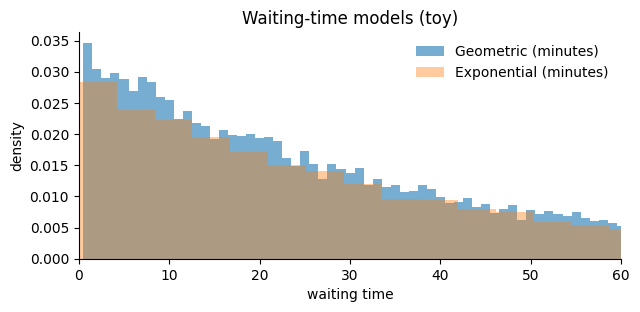

In [19]:
# Geometric vs Exponential (toy): waiting times
p = 0.03               # goal probability per minute (toy)
lam = p                # for small p, geometric ~ exponential with λ ≈ p per minute
N = 20_000

geo_wait = rng.geometric(p=p, size=N)         # 1,2,3,...
exp_wait = rng.exponential(scale=1/lam, size=N)

fig, ax = plt.subplots(figsize=(7,3), dpi=100)
ax.hist(geo_wait, bins=np.arange(0.5, 80.5, 1), density=True, alpha=0.6, label='Geometric (minutes)')
ax.hist(exp_wait, bins=80, density=True, alpha=0.4, label='Exponential (minutes)')
ax.set_xlim(0, 60)
ax.set_xlabel('waiting time')
ax.set_ylabel('density')
ax.set_title('Waiting-time models (toy)')
ax.legend(framealpha=0.0)
ax.spines[['right','top']].set_visible(False)
plt.show()


In [20]:
# Memoryless check (toy): geometric waiting time
p = 0.05
N = 200_000
wait = rng.geometric(p=p, size=N)

s = 5
t = 7

lhs = np.mean(wait > (s+t)) / np.mean(wait > s)   # P(wait>s+t | wait>s)
rhs = np.mean(wait > t)                           # P(wait>t)

print("Geometric memoryless check:")
print("P(W > s+t | W > s) =", lhs)
print("P(W > t)           =", rhs)


Geometric memoryless check:
P(W > s+t | W > s) = 0.6979339056681837
P(W > t)           = 0.699025


__________
## Data: Shots from the English Premier League in 2024-2025

We'll use an EPL 2024 shot-level dataset with (at least) these columns:

- `match_id`, `date`, `home_team`, `away_team`
- `minute` (shot minute; includes stoppage time when available)
- `result` (e.g., MissedShots, SavedShot, BlockedShot, Goal, OwnGoal, ...)
- `h_a` (home/away indicator for the shooting team)
- `xG` (expected goals for the shot)

We’ll start with a single match visualization, then aggregate across the season.


In [22]:
df = pd.read_csv('data/EPL_2024_shots.csv')
print(df.shape)

(9878, 22)


In [23]:
df.head()

,league,season,match_id,date,home_team,away_team,home_goals,away_goals,h_a,team,shot_id,minute,result,player,player_id,player_assisted,situation,shotType,lastAction,X,Y,xG
0,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,a,Fulham,584627,7,MissedShots,Adama Traoré,900,Rodrigo Muniz,OpenPlay,RightFoot,Pass,0.867,0.278,0.036473
1,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,a,Fulham,584628,12,SavedShot,Kenny Tete,5973,Andreas Pereira,OpenPlay,RightFoot,Pass,0.727,0.501,0.021440
2,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,a,Fulham,584629,13,BlockedShot,Rodrigo Muniz,10717,Andreas Pereira,FromCorner,Head,Cross,0.889,0.456,0.037385
3,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,h,Manchester United,584630,19,MissedShots,Bruno Fernandes,1228,Lisandro Martínez,OpenPlay,LeftFoot,Chipped,0.971,0.673,0.050078
4,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,h,Manchester United,584631,26,MissedShots,Casemiro,2248,Mason Mount,OpenPlay,RightFoot,Pass,0.747,0.479,0.020807


In [24]:
df.tail()

,league,season,match_id,date,home_team,away_team,home_goals,away_goals,h_a,team,shot_id,minute,result,player,player_id,player_assisted,situation,shotType,lastAction,X,Y,xG
9873,EPL,2024,26981,2025-05-25 15:00:00,Fulham,Manchester City,0,2,h,Fulham,636437,80,MissedShots,Joshua King,12410,Ryan Sessegnon,OpenPlay,Head,Aerial,0.939,0.380,0.462161
9874,EPL,2024,26981,2025-05-25 15:00:00,Fulham,Manchester City,0,2,h,Fulham,636438,88,BlockedShot,Kenny Tete,5973,Emile Smith-Rowe,FromCorner,RightFoot,Cross,0.948,0.613,0.056397
9875,EPL,2024,26981,2025-05-25 15:00:00,Fulham,Manchester City,0,2,h,Fulham,636439,91,BlockedShot,Alex Iwobi,500,Emile Smith-Rowe,OpenPlay,RightFoot,Pass,0.742,0.727,0.012584
9876,EPL,2024,26981,2025-05-25 15:00:00,Fulham,Manchester City,0,2,h,Fulham,636440,94,SavedShot,Sander Berge,8285,NaN,OpenPlay,LeftFoot,NaN,0.913,0.533,0.353645
9877,EPL,2024,26981,2025-05-25 15:00:00,Fulham,Manchester City,0,2,h,Fulham,636441,95,MissedShots,Raúl Jiménez,4105,Ryan Sessegnon,OpenPlay,RightFoot,Cross,0.906,0.541,0.079089


__________

## Case Study: December 22, 2024

We'll use Bournemouth’s 3–0 win at Old Trafford on December 22, 2024 as our running (very unbiased) example. It's an ideal example to look at our hands-on study of goal-scoring dynamics: three goals, lots of shots, etc.

![](images/bournemouth_united.jpg)
**Image from:** ESPN. (2024, December 22). Man United 0, Bournemouth 3: Premier League match report. ESPN. https://www.espn.com/soccer/report/_/gameId/704440.



In [25]:
game_id = 26769
df_mun_bou = df.loc[df['match_id']==game_id].copy()
df_mun_bou

,league,season,match_id,date,home_team,away_team,home_goals,away_goals,h_a,team,shot_id,minute,result,player,player_id,player_assisted,situation,shotType,lastAction,X,Y,xG
4436,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,h,Manchester United,608693,5,SavedShot,Amad Diallo Traore,8127,NaN,OpenPlay,LeftFoot,NaN,0.870,0.519,0.082709
4437,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,a,Bournemouth,608694,8,SavedShot,Antoine Semenyo,11363,Ryan Christie,OpenPlay,LeftFoot,Pass,0.792,0.516,0.042886
4438,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,h,Manchester United,608695,17,SavedShot,Bruno Fernandes,1228,Amad Diallo Traore,OpenPlay,RightFoot,Pass,0.721,0.708,0.011621
4439,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,a,Bournemouth,608696,23,MissedShots,Justin Kluivert,6963,Dean Huijsen,OpenPlay,RightFoot,Pass,0.769,0.439,0.027950
4440,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,a,Bournemouth,608697,27,BlockedShot,Antoine Semenyo,11363,Ryan Christie,OpenPlay,RightFoot,Pass,0.778,0.687,0.023058
4441,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,a,Bournemouth,608698,28,Goal,Dean Huijsen,11943,Ryan Christie,SetPiece,Head,Cross,0.924,0.452,0.121566
4442,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,a,Bournemouth,608699,30,SavedShot,Evanilson,12963,Illia Zabarnyi,OpenPlay,RightFoot,Chipped,0.800,0.489,0.060368
4443,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,h,Manchester United,608700,33,BlockedShot,Bruno Fernandes,1228,NaN,DirectFreekick,RightFoot,Standard,0.743,0.519,0.059678
4444,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,h,Manchester United,608701,34,BlockedShot,Manuel Ugarte,11766,Bruno Fernandes,SetPiece,Head,Aerial,0.958,0.548,0.097800
4445,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,h,Manchester United,608702,35,BlockedShot,Lisandro Martínez,10802,NaN,FromCorner,LeftFoot,NaN,0.904,0.328,0.045741


In [26]:
shot_times = df_mun_bou['minute'].values

### Visual: a match as a timeline of events

A “rug plot” is a simple way to show **when** shots (and goals) happen.


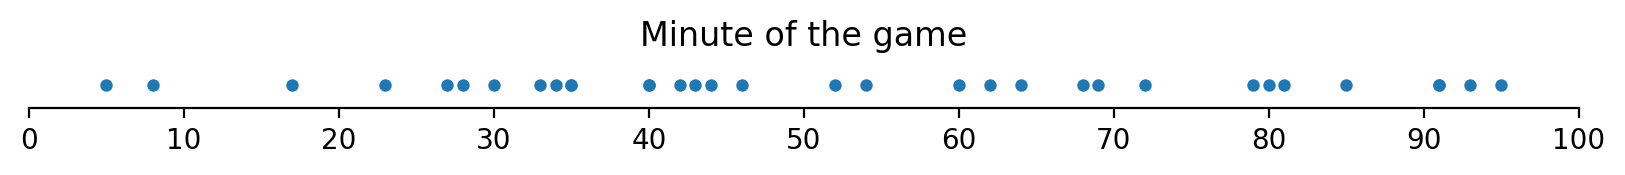

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,0.3),dpi=200)

ax.scatter(shot_times, [0]*len(shot_times), lw=0, s=20)


ax.set_yticks([])
ax.set_xticks(range(0,110,10))
ax.set_title('Minute of the game')
ax.spines[['right', 'top', 'left']].set_visible(False)



plt.show()

Can we separate by team?

In [28]:
h_or_a_team = df_mun_bou['h_a'].values

bournemouth_shots = [shot_times[i] for i,ha in enumerate(h_or_a_team) if ha=='a']
manc_united_shots = [shot_times[i] for i,ha in enumerate(h_or_a_team) if ha=='h']

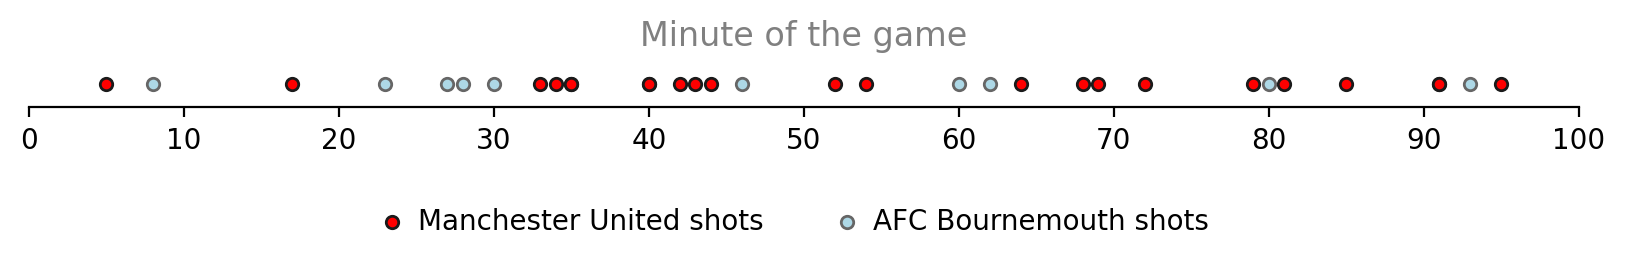

In [29]:
fig, ax = plt.subplots(1,1,figsize=(10,0.3),dpi=200)


# ax.scatter(shot_times, [0]*len(shot_times), lw=0, s=20)
ax.scatter(manc_united_shots, [0]*len(manc_united_shots), ec='.1', s=20,
           label='Manchester United shots', color='red')
ax.scatter(bournemouth_shots, [0]*len(bournemouth_shots), ec='.4', s=20,
           label='AFC Bournemouth shots', color='lightblue')


ax.legend(ncol=3,loc=2,bbox_to_anchor=[0.2, -1.65],framealpha=0.0,handletextpad=-0.05)


ax.set_yticks([])
ax.set_xticks(range(0,110,10))
ax.set_title('Minute of the game',color='.5')
ax.spines[['right', 'top', 'left']].set_visible(False)



plt.show()

_____________

What about goals?

In [30]:
goal_times = df_mun_bou.loc[df_mun_bou['result'].isin(['Goal','OwnGoal'])]['minute'].values

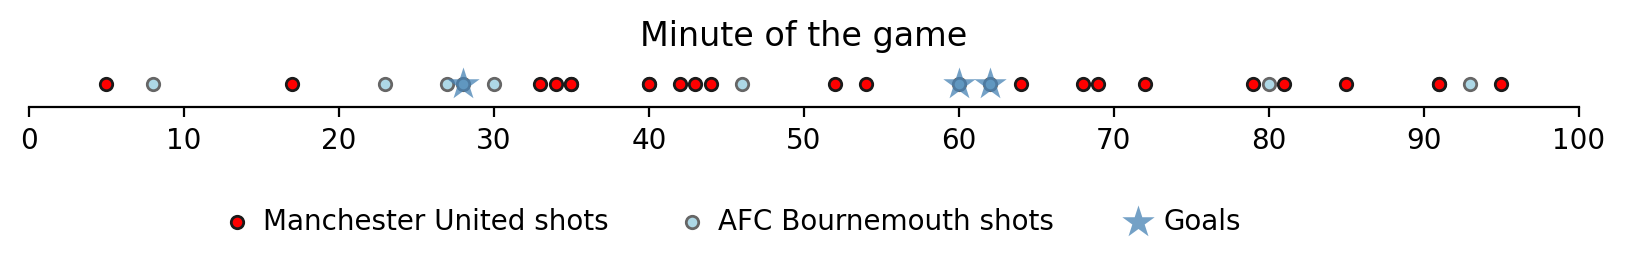

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,0.3),dpi=200)


# ax.scatter(shot_times, [0]*len(shot_times), lw=0, s=20)
ax.scatter(manc_united_shots, [0]*len(manc_united_shots), ec='.1', s=20,
           label='Manchester United shots', color='red')
ax.scatter(bournemouth_shots, [0]*len(bournemouth_shots), ec='.4', s=20,
           label='AFC Bournemouth shots', color='lightblue')

ax.scatter(goal_times, [0.0]*len(goal_times), lw=0, s=150, label='Goals',
           color='steelblue', marker='*', alpha=0.75)


ax.legend(ncol=3,loc=2,bbox_to_anchor=[0.1, -1.65],framealpha=0.0,handletextpad=-0.05)


ax.set_yticks([])
ax.set_xticks(range(0,110,10))
ax.set_title('Minute of the game')
ax.spines[['right', 'top', 'left']].set_visible(False)



plt.show()

_________

## How to get time between goals?
Recall from the slides, we want this value?

![](images/slides.png)

### Time between goals (within a match)

For a match with goal minutes $t_1 < t_2 < \dots < t_m$, the between-goal times are:

$$
\Delta_i = t_i - t_{i-1}.
$$

(We’ll compute these and then aggregate across matches.)


In [32]:
df_mun_bou.loc[df_mun_bou['result'].isin(['Goal','OwnGoal'])]

,league,season,match_id,date,home_team,away_team,home_goals,away_goals,h_a,team,shot_id,minute,result,player,player_id,player_assisted,situation,shotType,lastAction,X,Y,xG
4441,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,a,Bournemouth,608698,28,Goal,Dean Huijsen,11943,Ryan Christie,SetPiece,Head,Cross,0.924,0.452,0.121566
4455,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,a,Bournemouth,608712,60,Goal,Justin Kluivert,6963,NaN,Penalty,RightFoot,Standard,0.885,0.500,0.761169
4456,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,a,Bournemouth,608713,62,Goal,Antoine Semenyo,11363,Dango Ouattara,OpenPlay,LeftFoot,Pass,0.906,0.516,0.564983


In [33]:
df_mun_bou.loc[df_mun_bou['result'].isin(['Goal','OwnGoal'])]['minute'].diff()

4441     NaN
4455    32.0
4456     2.0
Name: minute, dtype: float64

In [34]:
df_mun_bou.loc[df_mun_bou['result'].isin(['Goal','OwnGoal'])]['minute'].diff().dropna().values.astype(int).tolist()

[32, 2]

## Your turn: Get the inter-goal time for every match in the season
Work in pairs to create this.

In [35]:
pass

## We also have data from *six* leagues, over 10 seasons each. Does the pattern still hold?

`data/shot_times_six_leagues.csv`

In [36]:
df_all = pd.read_csv('data/shot_times_six_leagues.csv')
df_all['total_goals'] = df_all['home_goals'] + df_all['away_goals']
df_all_shots = df_all.loc[df_all['total_goals']>1].copy()
df_all_goals = df_all_shots.loc[df_all_shots['result'].isin(['Goal','OwnGoal'])].copy()
df_all_goals['goal_timediff'] = df_all_goals.groupby('match_id')['minute'].diff()

dfg = df_all_goals.loc[~df_all_goals['goal_timediff'].isna()].copy()

goaldiff_dict = {i:0 for i in range(105)}
for gt in dfg['goal_timediff']:
    goaldiff_dict[gt] += 1

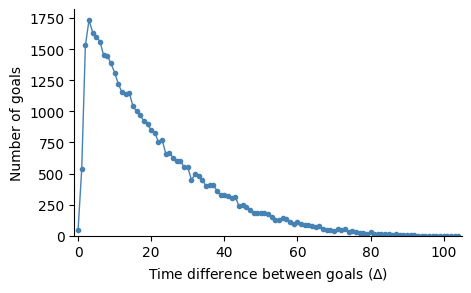

In [37]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=100)

minutes = list(goaldiff_dict.keys())
goaldiff_vals = np.array(list(goaldiff_dict.values()))
goaldiff_vals_norm = goaldiff_vals/sum(goaldiff_vals)

ax.plot(minutes, goaldiff_vals, color='steelblue', marker='.', lw=1)
# ax.plot(minutes, goaldiff_vals_norm, color='.2', lw=2)

ax.set_xlabel(r'Time difference between goals ($\Delta$)')
# ax.set_ylabel('Fraction of goals')
ax.set_ylabel('Number of goals')
ax.set_ylim(0)
ax.set_xlim(-1,105)
ax.spines[['right', 'top']].set_visible(False)

# plt.savefig('images/pngs/timediff_goals.png',dpi=425,bbox_inches='tight')
# plt.savefig('images/pdfs/timediff_goals.pdf',dpi=425,bbox_inches='tight')
plt.show()

This phenomenon is explored in: Ayana, G., Ehlert, A., Ehlert, J., Santagata, L., Torricelli, M., & Klein, B. (2025). Temporal dynamics of goal scoring in soccer (Preprint). arXiv. https://doi.org/10.48550/arXiv.2501.18606

## Lastly: Minimal model of goal-scoring dynamics. Would we expect this? Are we surprised?


If we assume that a goal happens in each minute with constant probability $p$, then:

- waiting times (in minutes) should be **geometric**
- mean waiting time should be about $1/p$
- the process should be **memoryless**

We’ll compute waiting times as:
- time from kickoff → first goal
- then time between subsequent goals

**Note:** matches with zero goals produce *right-censored* waiting times (we’ll ignore censoring today).


Number of waiting times: 1103
Mean waiting time (minutes): 23.240253853127832
Geometric p-hat (1/mean): 0.04302878988842943


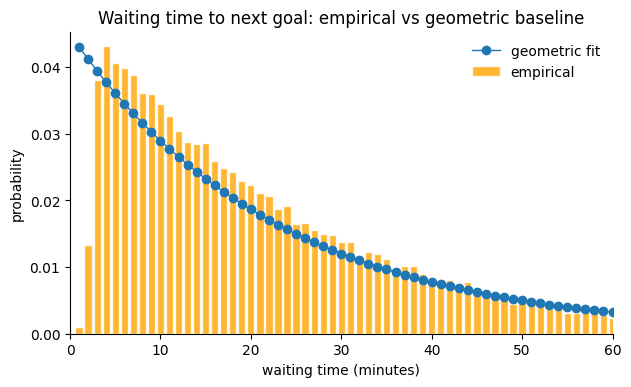

In [39]:
if df is not None:
    goal_events = df[df['result'].isin(['Goal','OwnGoal'])].sort_values(['match_id','minute'])

    waits = []
    for match_id, g in goal_events.groupby('match_id'):
        mins = g['minute'].values
        if len(mins) == 0:
            continue
        # waits include time to first goal (from minute 0)
        w = np.diff(np.insert(mins, 0, 0))
        waits.extend(w)

    waits = np.array(waits, dtype=float)
    waits = waits[waits >= 1]  # drop 0-minute waits (can happen if multiple goals logged in same minute)

    print("Number of waiting times:", len(waits))
    print("Mean waiting time (minutes):", waits.mean())

    # Geometric parameter estimate via mean: E[W]=1/p  => p_hat = 1/mean
    p_hat = 1.0 / waits.mean()
    print("Geometric p-hat (1/mean):", p_hat)

    max_k = int(np.percentile(waits, 99))
    k = np.arange(1, max_k+1)

    theo = geometric_pmf(k, p=p_hat)

    fig, ax = plt.subplots(figsize=(7,4), dpi=100)
    ax.bar(k, goaldiff_vals_norm[:80], edgecolor='white', alpha=0.8, label='empirical', color='orange')
    ax.plot(k, theo, marker='o', linewidth=1, label='geometric fit')
    ax.set_xlabel('waiting time (minutes)')
    ax.set_ylabel('probability')
    ax.set_title('Waiting time to next goal: empirical vs geometric baseline')
    ax.set_xlim(0, min(max_k, 60))
    ax.legend(framealpha=0.0)
    ax.spines[['right','top']].set_visible(False)
    plt.show()


### Reality check: is goal probability constant over match time?

Geometric/exponential waiting time models assume a constant rate/probability.

But in real matches:
- game state changes (leading/trailing)
- fatigue and substitutions change tempo
- stoppage time is weird

Let’s estimate “goals per minute” across the season.


<!-- ## Model critique

Our baseline models (Poisson / geometric / exponential) rely on strong assumptions:

1. **Stationarity:** the event rate is constant in time  
2. **Independence:** goals don’t change the process that generates future goals  
3. **Homogeneity:** all matches (and teams) share the same parameters

Sports violations are the interesting part:
- tactics + game state create time-varying rates
- teams differ (mixtures of “open” and “closed” games)
- a goal can change behavior immediately (“contagion”)

A good workflow is:
> propose a simple model → compare to data → learn *which* assumption breaks → iterate
 -->

__________
## Next time...
Regression Pt. 1 — Moneyball Replication `class_05_regression_01_moneyball.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Github: https://github.com/jkbren/cnet5442_sp26
    - Syllabus and course details: https://brennanklein.com/cnet5442-spring26
2. Pascal, Fermat, and the “problem of points”
    - APS News (2009): https://www.aps.org/apsnews/2009/07/pascal-letters-fermat-points
    - Hacking, I. (1975). *The Emergence of Probability*. Cambridge University Press.
3. A solid probability reference (discrete + continuous RVs, LLN)
    - MIT OCW 6.041: *Probabilistic Systems Analysis and Applied Probability*
    - MIT OCW 18.440: *Probability and Random Variables*
4. Information theory (surprise / entropy)
    - Shannon, C. E. (1948). *A Mathematical Theory of Communication*. Bell System Technical Journal.
5. Soccer scoring models (classic)
    - Maher, M. J. (1982). *Modelling Association Football Scores*. Statistica Neerlandica.
    - Dixon, M. J., & Coles, S. G. (1997). *Modelling Association Football Scores and Inefficiencies in the Football Betting Market*. JRSS-C.
6. Python tools used here
    - NumPy, Matplotlib, Pandas documentation


## Supplemental Information: Weak LLN: a short proof sketch

Assume:
- $X_1,\dots,X_n$ are independent and identically distributed (i.i.d.)
- $E[X_i]=\mu$
- $\mathrm{Var}(X_i)=\sigma^2 < \infty$

Let $\bar X_n = \frac{1}{n}\sum_{i=1}^n X_i$.

**Step 1: mean and variance of the average**

$$
E[\bar X_n]=\mu,\qquad \mathrm{Var}(\bar X_n)=\frac{\sigma^2}{n}.
$$

**Step 2: Chebyshev’s inequality**  
For any random variable $Y$ with finite variance:

$$
P(|Y-E[Y]|\ge \varepsilon)\le \frac{\mathrm{Var}(Y)}{\varepsilon^2}.
$$

Apply to $Y=\bar X_n$:

$$
P(|\bar X_n-\mu|\ge \varepsilon)\le \frac{\sigma^2}{n\varepsilon^2}.
$$

As $n\to\infty$, the right-hand side goes to **0**, so:

$$
P(|\bar X_n-\mu|\ge \varepsilon)\to 0.
$$

That’s the "Weak" Law of Large Numbers.

In [40]:
# Chebyshev bound vs empirical probability (for Bernoulli)
p_true = 0.3
sigma2 = p_true * (1 - p_true)

eps = 0.05
M = 20_000
ns = [10, 50, 200, 1000, 5000]

rows = []
for n in ns:
    means = rng.binomial(n=1, p=p_true, size=(M, n)).mean(axis=1)
    empirical = np.mean(np.abs(means - p_true) >= eps)
    cheb_bound = sigma2 / (n * eps**2)
    rows.append((n, empirical, cheb_bound))

cheb_df = pd.DataFrame(rows, columns=["n", "empirical P(|mean-p|>=eps)", "Chebyshev bound"])
cheb_df


,n,empirical P(|mean-p|>=eps),Chebyshev bound
0,10,0.73200,8.4000
1,50,0.43540,1.6800
2,200,0.10650,0.4200
3,1000,0.00035,0.0840
4,5000,0.00000,0.0168


In [41]:
def find_repo_root(start: Optional[Path] = None) -> Path:
    """Walk upward until we find a folder that looks like the repo root."""
    start = Path.cwd() if start is None else Path(start)
    for parent in [start] + list(start.parents):
        if (parent / "README.md").exists() and (parent / "notebooks").exists():
            return parent
    return start

def surprisal_bits(p):
    """Surprisal (in bits): -log2(p)."""
    p = np.asarray(p, dtype=float)
    return -np.log2(p)

def implied_prob_decimal(decimal_odds: float) -> float:
    """Decimal odds -> implied probability (no vig adjustment)."""
    return 1.0 / decimal_odds

def implied_prob_american(american_odds: float) -> float:
    """American odds -> implied probability (no vig adjustment)."""
    if american_odds > 0:
        return 100.0 / (american_odds + 100.0)
    else:
        a = abs(american_odds)
        return a / (a + 100.0)